In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/20.jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/6.jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/5_processed (3).jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/7_processed (1).jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/7_processed (2).jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/4_processed(3).jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/5.jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/8.jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/9_processed (2).jpg
/kaggle/input/fabric-defect-da

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision import models, transforms
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from torch.optim.lr_scheduler import CosineAnnealingLR
from collections import Counter

In [15]:
class FabricDefectDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                images.append((img_path, self.class_to_idx[cls]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [16]:
# Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [17]:
# Load dataset
dataset = FabricDefectDataset(root_dir='/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset')
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [18]:
# Apply transforms
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

In [19]:
# Oversampling with WeightedRandomSampler
train_labels = [label for _, label in train_dataset]
class_counts = Counter(train_labels)
class_weights = {cls: 1.0/class_counts[cls] for cls in class_counts}
sample_weights = [class_weights[label] for label in train_labels]

In [20]:
# Create sampler
max_count = max(class_counts.values())
num_classes = len(class_counts)
total_samples = num_classes * max_count
sampler = WeightedRandomSampler(sample_weights, num_samples=total_samples, replacement=True)

In [21]:
# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [22]:
# Model setup
model = models.vgg19(pretrained=True)

# Modify classifier
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(dataset.classes))

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Loss function with class weights
class_weights_tensor = torch.tensor([class_weights[i] for i in sorted(class_weights)], dtype=torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
class_weights_tensor = class_weights_tensor.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=15, eta_min=0.00001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 238MB/s] 


Epoch [1/15]
Train Loss: 0.1715 | Train Acc: 90.57%
Test Loss: 0.3607 | Test Acc: 93.09%
Epoch [2/15]
Train Loss: 0.0304 | Train Acc: 97.40%
Test Loss: 0.7194 | Test Acc: 94.12%
Epoch [3/15]
Train Loss: 0.0140 | Train Acc: 98.68%
Test Loss: 0.5321 | Test Acc: 94.88%
Epoch [4/15]
Train Loss: 0.0036 | Train Acc: 98.91%
Test Loss: 0.5373 | Test Acc: 94.88%
Epoch [5/15]
Train Loss: 0.0023 | Train Acc: 99.20%
Test Loss: 0.5037 | Test Acc: 95.14%
Epoch [6/15]
Train Loss: 0.0021 | Train Acc: 99.11%
Test Loss: 0.5662 | Test Acc: 95.40%
Epoch [7/15]
Train Loss: 0.0012 | Train Acc: 99.61%
Test Loss: 0.6599 | Test Acc: 95.91%
Epoch [8/15]
Train Loss: 0.0006 | Train Acc: 99.77%
Test Loss: 0.7318 | Test Acc: 94.63%
Epoch [9/15]
Train Loss: 0.0017 | Train Acc: 99.57%
Test Loss: 0.7080 | Test Acc: 95.91%
Epoch [10/15]
Train Loss: 0.0009 | Train Acc: 99.73%
Test Loss: 0.6350 | Test Acc: 95.40%
Epoch [11/15]
Train Loss: 0.0002 | Train Acc: 99.98%
Test Loss: 0.6266 | Test Acc: 95.40%
Epoch [12/15]
Train

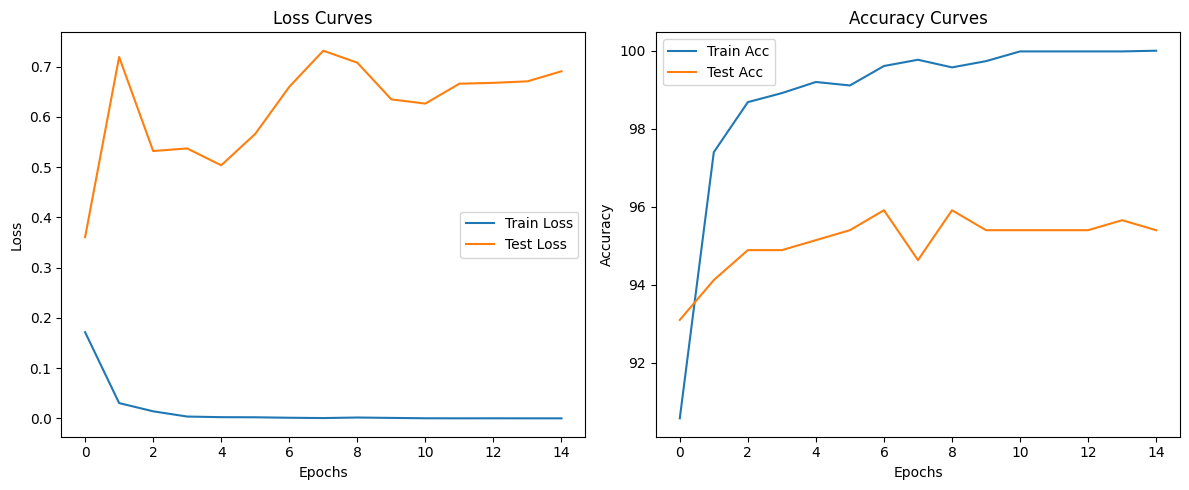

In [23]:
# Training loop
num_epochs = 15
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Testing
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct_test / total_test
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
    scheduler.step()

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Save model
torch.save(model.state_dict(), 'VGG19_Fabric_Defect.pth')



Test Loss: 0.6909, Test Accuracy: 95.40%


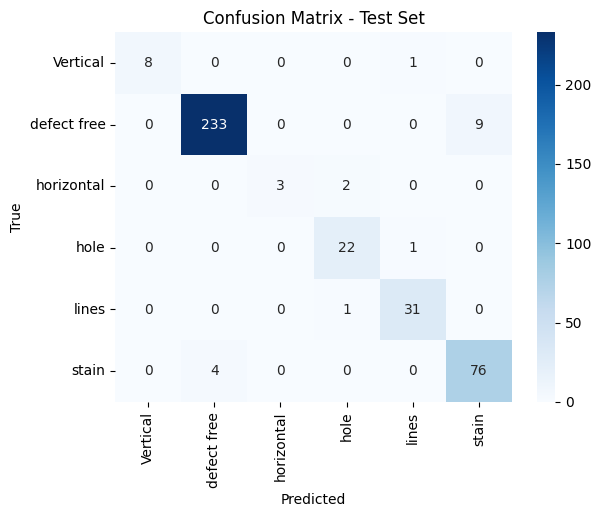

Classification Report - Test Set
              precision    recall  f1-score   support

    Vertical       1.00      0.89      0.94         9
 defect free       0.98      0.96      0.97       242
  horizontal       1.00      0.60      0.75         5
        hole       0.88      0.96      0.92        23
       lines       0.94      0.97      0.95        32
       stain       0.89      0.95      0.92        80

    accuracy                           0.95       391
   macro avg       0.95      0.89      0.91       391
weighted avg       0.96      0.95      0.95       391



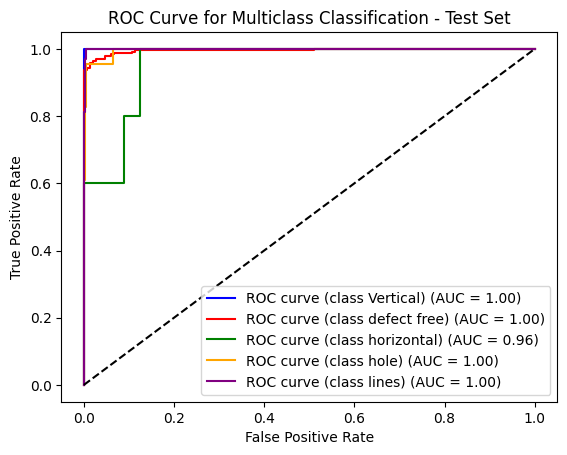


Image Index: 8
True Label: defect free
Predicted Label: stain
Class Probabilities: [2.7398337e-05 6.6761658e-02 1.1385493e-05 5.9031147e-05 2.6305865e-05
 9.3311417e-01]


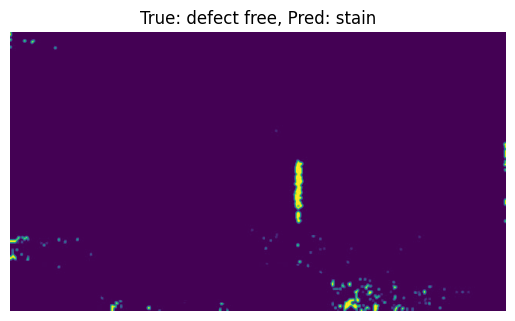


Image Index: 51
True Label: lines
Predicted Label: hole
Class Probabilities: [3.9155228e-05 5.7367706e-05 4.9572900e-05 8.2293165e-01 1.7675133e-01
 1.7086667e-04]


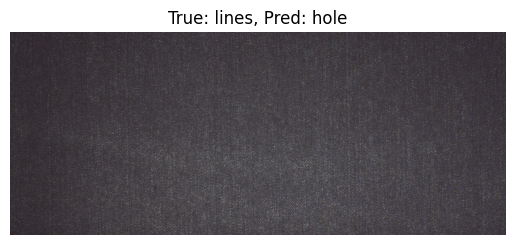


Image Index: 59
True Label: Vertical
Predicted Label: lines
Class Probabilities: [1.0141764e-02 3.2168828e-04 1.0259962e-01 1.5200477e-06 8.7302917e-01
 1.3906274e-02]


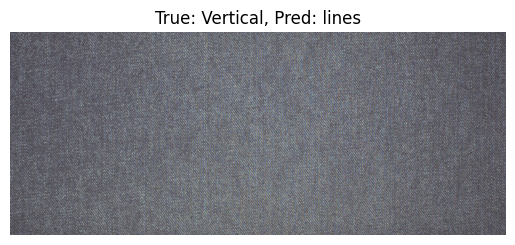


Image Index: 90
True Label: defect free
Predicted Label: stain
Class Probabilities: [6.0615002e-06 3.1900480e-02 2.9573584e-06 3.1986081e-05 3.6937906e-06
 9.6805489e-01]


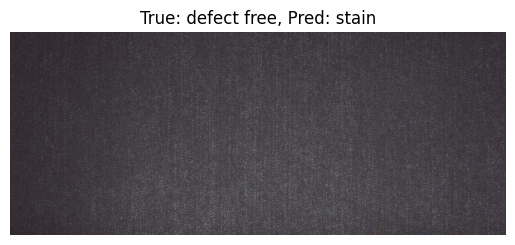


Image Index: 116
True Label: stain
Predicted Label: defect free
Class Probabilities: [2.7885522e-05 9.9916971e-01 4.2668446e-05 3.4628978e-05 3.0001913e-05
 6.9509808e-04]


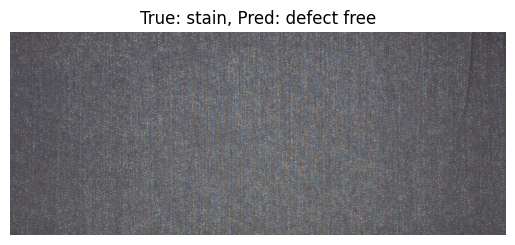


Image Index: 118
True Label: stain
Predicted Label: defect free
Class Probabilities: [8.6262153e-06 8.8915968e-01 4.7972940e-06 2.2101147e-05 1.1480508e-05
 1.1079329e-01]


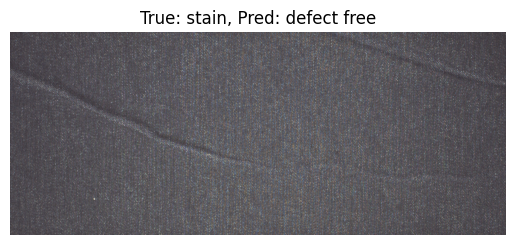


Image Index: 119
True Label: defect free
Predicted Label: stain
Class Probabilities: [2.2242895e-05 2.9637831e-01 1.1146359e-04 3.5407604e-05 1.9180465e-05
 7.0343339e-01]


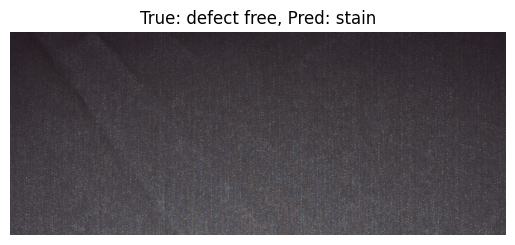


Image Index: 132
True Label: defect free
Predicted Label: stain
Class Probabilities: [5.2543041e-06 5.9859093e-02 1.0107713e-05 2.0705451e-05 4.5826409e-06
 9.4010019e-01]


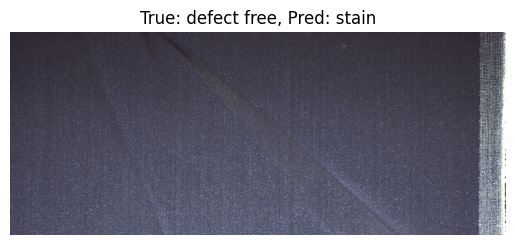


Image Index: 236
True Label: horizontal
Predicted Label: hole
Class Probabilities: [8.3998208e-10 7.3368898e-09 1.8550280e-07 9.9999964e-01 1.2092957e-08
 6.6582345e-08]


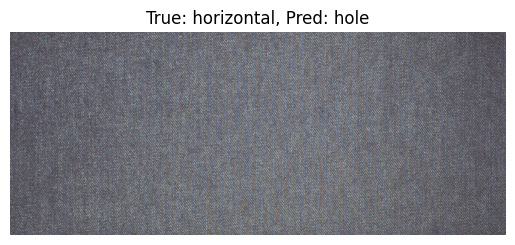


Image Index: 237
True Label: defect free
Predicted Label: stain
Class Probabilities: [4.1818625e-05 1.4478502e-02 8.1935876e-05 4.3518743e-03 4.3530385e-05
 9.8100233e-01]


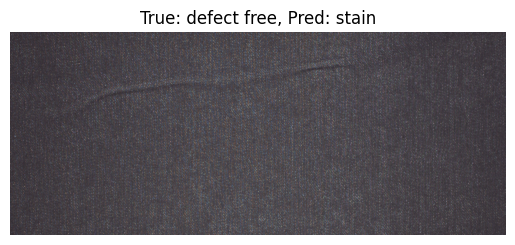

In [24]:
# Evaluate on the test set
model.eval()
test_loss = 0.0
correct = 0
total = 0
true_labels, predicted_labels, predictions = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        predictions.extend(torch.softmax(outputs, dim=1).cpu().numpy())

test_loss /= len(test_loader)
test_acc = 100. * correct / total

print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Classification Report
print("Classification Report - Test Set")
print(classification_report(true_labels, predicted_labels, target_names=dataset.classes))

# ROC/AUC Curve for Multiclass Classification
true_labels_bin = label_binarize(true_labels, classes=np.arange(len(dataset.classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], np.array(predictions)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple']  # Add more colors if needed
for i, color in zip(range(len(dataset.classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f'ROC curve (class {dataset.classes[i]}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification - Test Set')
plt.legend(loc="lower right")
plt.show()

# Misclassified Images
misclassified_idx = [i for i, (p, t) in enumerate(zip(predicted_labels, true_labels)) if p != t]
for idx in misclassified_idx[:10]:  # Limit to first 10 for visualization
    true_label = dataset.classes[true_labels[idx]]
    predicted_label = dataset.classes[predicted_labels[idx]]
    probabilities = predictions[idx]

    print(f"\nImage Index: {idx}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Class Probabilities: {probabilities}")

    # Visualize the misclassified image
    img = Image.open(dataset.images[idx][0])
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {predicted_label}")
    plt.xlabel(f"Probs: {probabilities}")
    plt.axis('off')
    plt.show()